In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [2]:
base_train_data = pd.read_csv('Training.csv', sep=';',decimal=',', encoding='utf-8',low_memory=False, index_col=['ID'])
base_test_data = pd.read_csv('Test.csv', sep=';',decimal=',', encoding='utf-8', low_memory=False, index_col=['ID'])

In [3]:
base_train_data['train/test'] = 'train'
base_test_data['train/test'] = 'test'

In [4]:
all_data = pd.concat([base_train_data, base_test_data], axis=0).reset_index(drop=True)

# EDA

In [5]:
all_data.head()

A     B      C       D     E     F   G     H      I      J  ...  \
0  0.20  0.10   0.00  799.90  1.78  0.89  13  3.49  Woman  33.75  ...   
1  0.04  0.02  49.97  173.03  0.38  0.19  13  3.49  Woman  33.25  ...   
2  0.07  0.07   0.00  329.90  0.60  0.60  13  3.49  Woman  38.58  ...   
3  0.05  0.05   0.00  235.65  0.47  0.47  13  3.49  Woman  61.25  ...   
4  0.14  0.14   0.00  634.45  1.27  1.27  13  3.49  Woman  48.58  ...   

           Q   R          S    T    U    V    W   X MARKER train/test  
0   property  No      Works  Yes  Yes   No  Yes  No      0      train  
1  otherwise  No      Works  Yes  Yes  Yes  Yes  No      0      train  
2   property  No  No couple   No  Yes   No  Yes  No      0      train  
3   property  No  No couple  Yes  Yes  Few  Yes  No      0      train  
4   property  No  No couple  Yes   No   No   No  No      0      train  

[5 rows x 26 columns]

In [6]:
all_data.shape

(128139, 26)

In [7]:
all_data.dtypes

A             float64
B             float64
C             float64
D             float64
E             float64
F             float64
G               int64
H             float64
I              object
J             float64
K              object
L               int64
M              object
N              object
O              object
P              object
Q              object
R              object
S              object
T              object
U              object
V              object
W              object
X              object
MARKER          int64
train/test     object
dtype: object

In [8]:
all_data.isnull().sum()

A             0
B             0
C             0
D             0
E             0
F             0
G             0
H             0
I             0
J             0
K             0
L             0
M             0
N             0
O             0
P             0
Q             0
R             0
S             0
T             0
U             0
V             0
W             0
X             0
MARKER        0
train/test    0
dtype: int64

Пропущенные значения в наборе данных отсутствуют

In [9]:
all_data.describe().T

count        mean         std    min     25%     50%     75%  \
A       128139.0    0.167107    0.152463   0.00    0.07    0.12    0.22   
B       128139.0    0.113126    0.104995   0.00    0.04    0.08    0.15   
C       128139.0   85.704254  105.423363   0.00   20.43   50.02  108.57   
D       128139.0  549.108039  450.407616  49.98  227.03  408.49  745.73   
E       128139.0    1.010425    0.911472   0.00    0.41    0.75    1.33   
F       128139.0    0.683140    0.622441   0.00    0.26    0.50    0.90   
G       128139.0    7.872584    4.768993   2.00    4.00    5.00   13.00   
H       128139.0    0.512201    0.929954   0.00    0.00    0.00    0.01   
J       128139.0   41.109281   11.137880  21.00   32.00   39.92   50.00   
L       128139.0  103.767659  100.340082   0.00   29.00   70.00  144.00   
MARKER  128139.0    0.003808    0.061595   0.00    0.00    0.00    0.00   

            max  
A          7.07  
B          0.87  
C       2682.42  
D       4999.00  
E         35.34  
F         10.35  
G         24.00  
H          3.50  
J         64.92  
L        545.00  
MARKER     1.00

Анализируем структуру категориальных признаков в обучающей и тренировочной выборке

In [10]:
cat_features = all_data.select_dtypes(include='object')
for i in cat_features:
    df_new = pd.merge(pd.DataFrame({'train': base_train_data[i].value_counts()}), pd.DataFrame({'test': base_test_data[i].value_counts()}), how='inner', on=i)
    df_new['train_%'] = df_new['train']/sum(df_new['train'])
    df_new['test_%'] = df_new['test']/sum(df_new['test'])
    print(df_new)
    print('-'*80)

       train   test   train_%    test_%
I                                      
Woman  48996  20701  0.546014  0.539018
Man    40738  17704  0.453986  0.460982
--------------------------------------------------------------------------------
                train  test   train_%    test_%
K                                              
Minsk region    15274  6567  0.170214  0.170993
Minsk           14012  5991  0.156150  0.155995
Brest region    13897  5952  0.154869  0.154980
Grodno region   12614  5432  0.140571  0.141440
Vitebsk region  12560  5455  0.139969  0.142039
Gomel region    12493  5241  0.139223  0.136467
Mogilev region   8884  3767  0.099004  0.098086
--------------------------------------------------------------------------------
                             train   test   train_%    test_%
M                                                            
NE employee                  72475  31047  0.807665  0.808410
Head/Deputy head (division)   6304   2728  0.070252  0.07103

Делаем заключение о том, что данные в категориальных переменных в тренировочной и тестовой выборках распределены идентично

In [5]:
num_features = all_data.select_dtypes(include=['float64','int64']).drop('MARKER', axis=1).columns

Затем проанализируем распределение числовых переменных также для обучающей и тестовой выборках

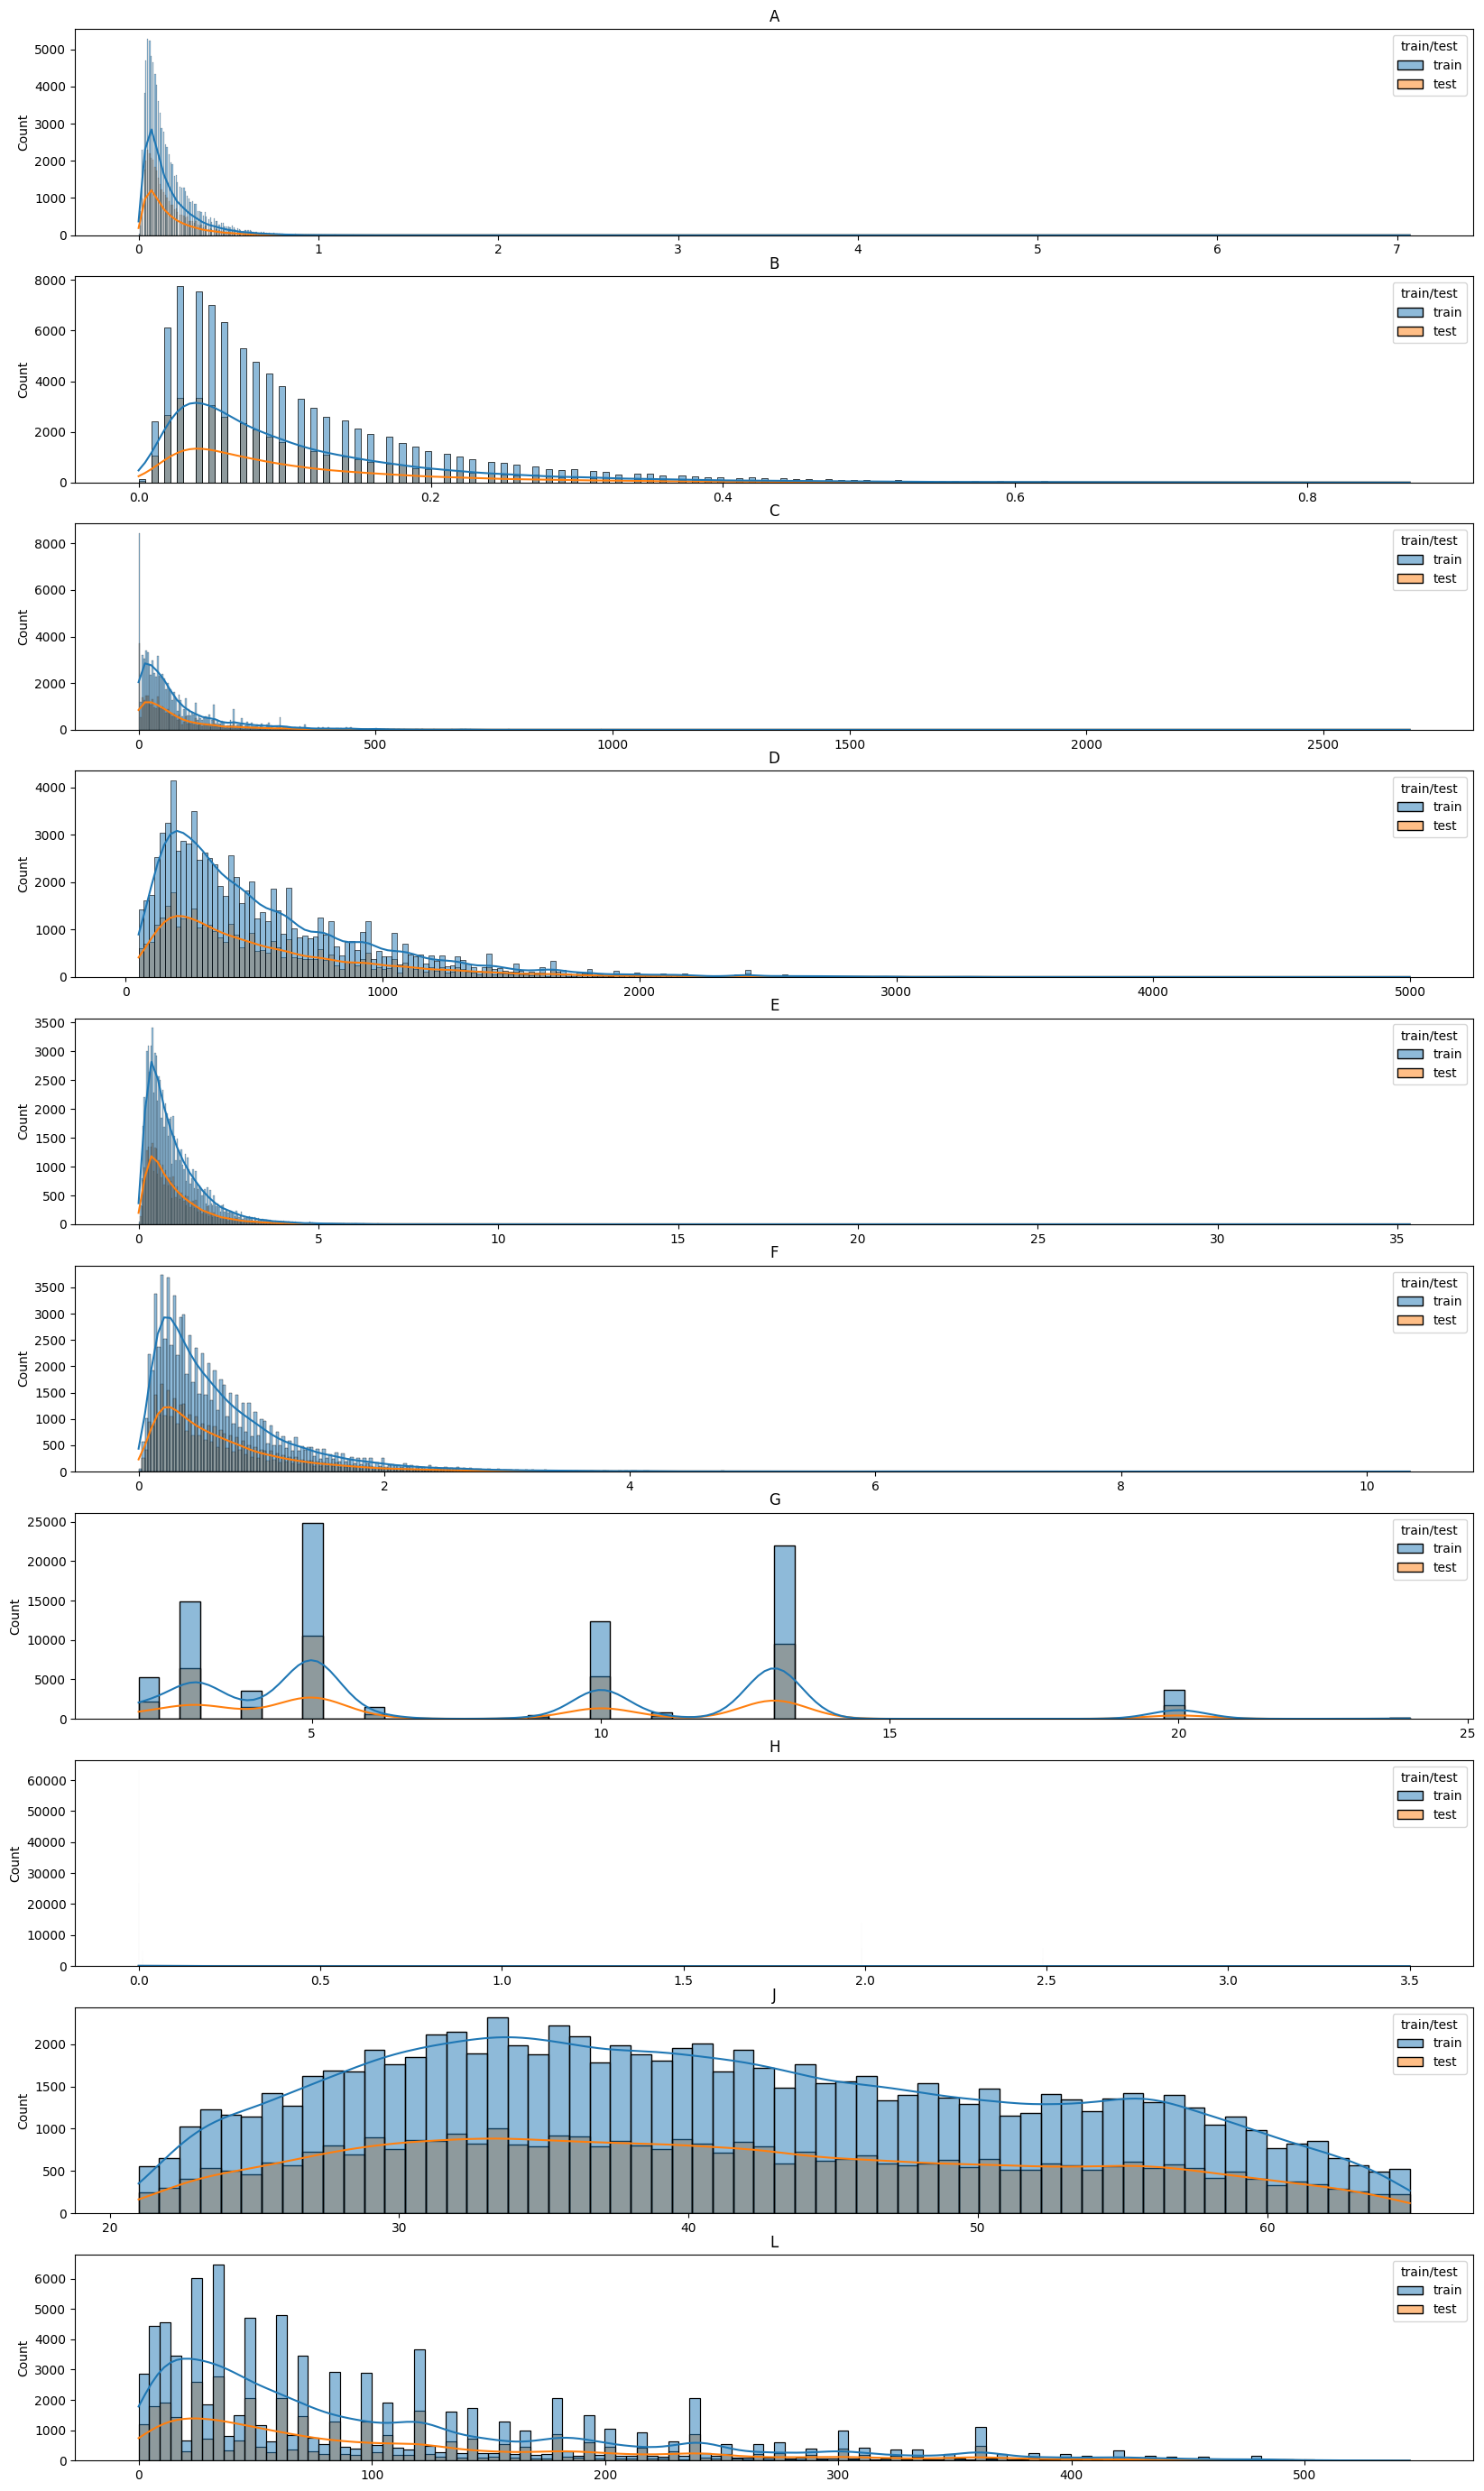

In [12]:
fig, ax = plt.subplots(len(num_features),figsize=(20, 35))
for idx, feature in enumerate(num_features):
    sns.histplot(all_data, x=feature, hue='train/test', kde=True, ax=ax[idx])
    ax[idx].set_title(num_features[idx])
    ax[idx].set_xlabel('')
plt.show()

Замечаем, что во всех переменных кроме J присутствуют выбросы, данные перекошены в левую сторону. Структурно в обучающей и тестовой выборке данные распределены идентично. В связи с вышеизложенным делаем заключение о том, что обе выборки (обучающая и тестовая) принадлежат одной генеральной совокупности

Далее построим диаграммы размаха в разрезе целевой переменной

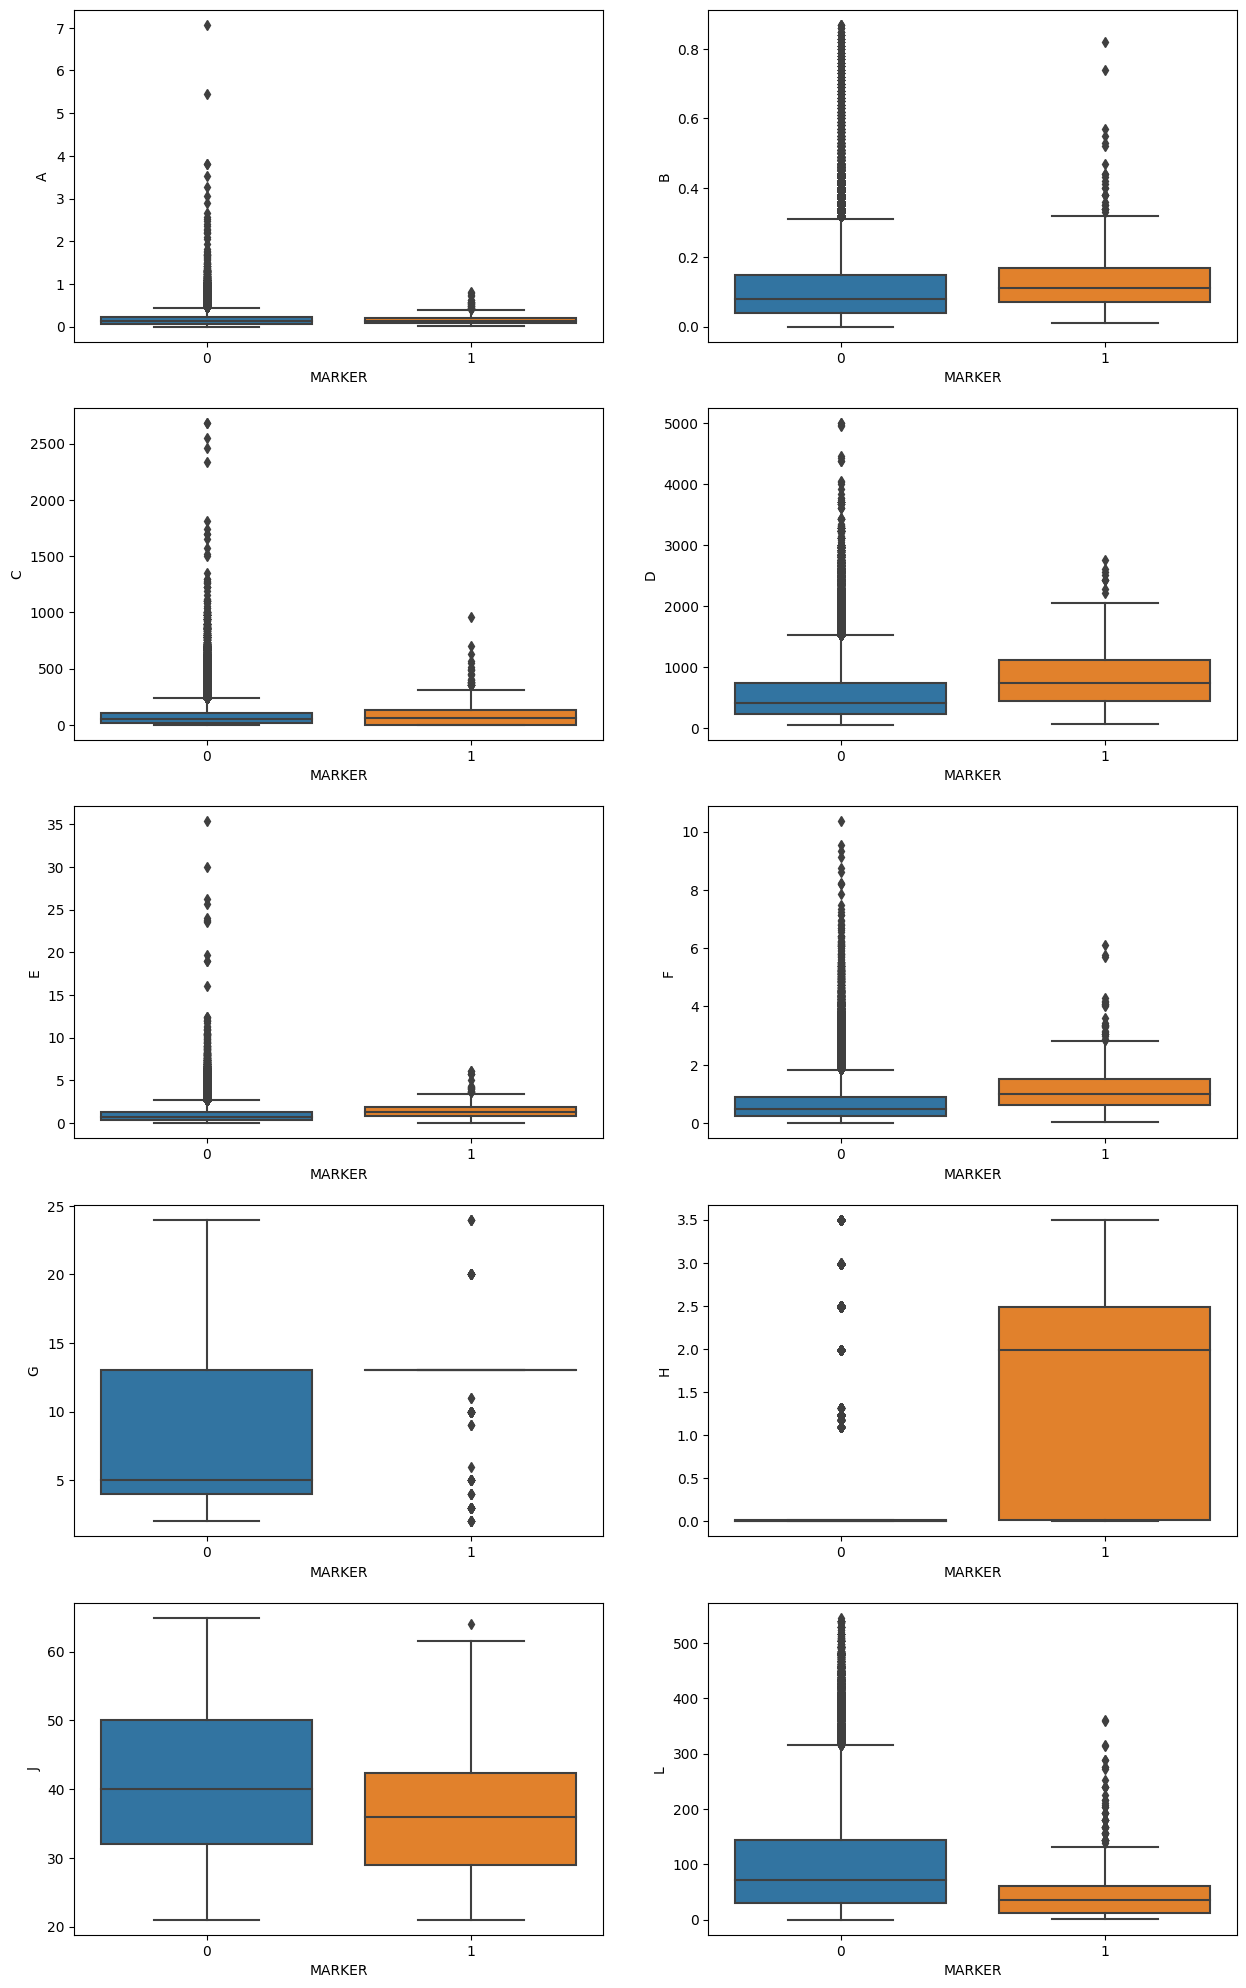

In [13]:
cols = 2
rows = len(num_features)//cols
fig, ax = plt.subplots(rows, cols, figsize=(15, 25))
for idx, feature in enumerate(num_features):
    col = idx%cols
    row = idx//cols
    sns.boxplot(all_data, x='MARKER', y=feature, ax=ax[row][col])
plt.show()

Подтверждаем гипотезу о наличии выбросов. А также замечаем что переменные G и H достаточно явно разделяют классы

В связи с тем, что данные распределены с перекосом, для обработки выбросов применим стратегию замены экстремальных значений на граничные по правилу 1.5 IQR

In [6]:
data_proc_extr = all_data.copy()
for i in num_features:
    IQR = data_proc_extr[i].quantile(0.75)-data_proc_extr[i].quantile(0.25)
    upper = data_proc_extr[i].quantile(0.75) + 1.5*IQR
    lower = data_proc_extr[i].quantile(0.25) - 1.5*IQR
    data_proc_extr[i] = np.where(data_proc_extr[i]>=upper, upper, data_proc_extr[i])
    data_proc_extr[i] = np.where(data_proc_extr[i]<=lower, lower, data_proc_extr[i])

Посмотрим на распределение числовых переменных в разрезе таргетной метки после обработки выбросов

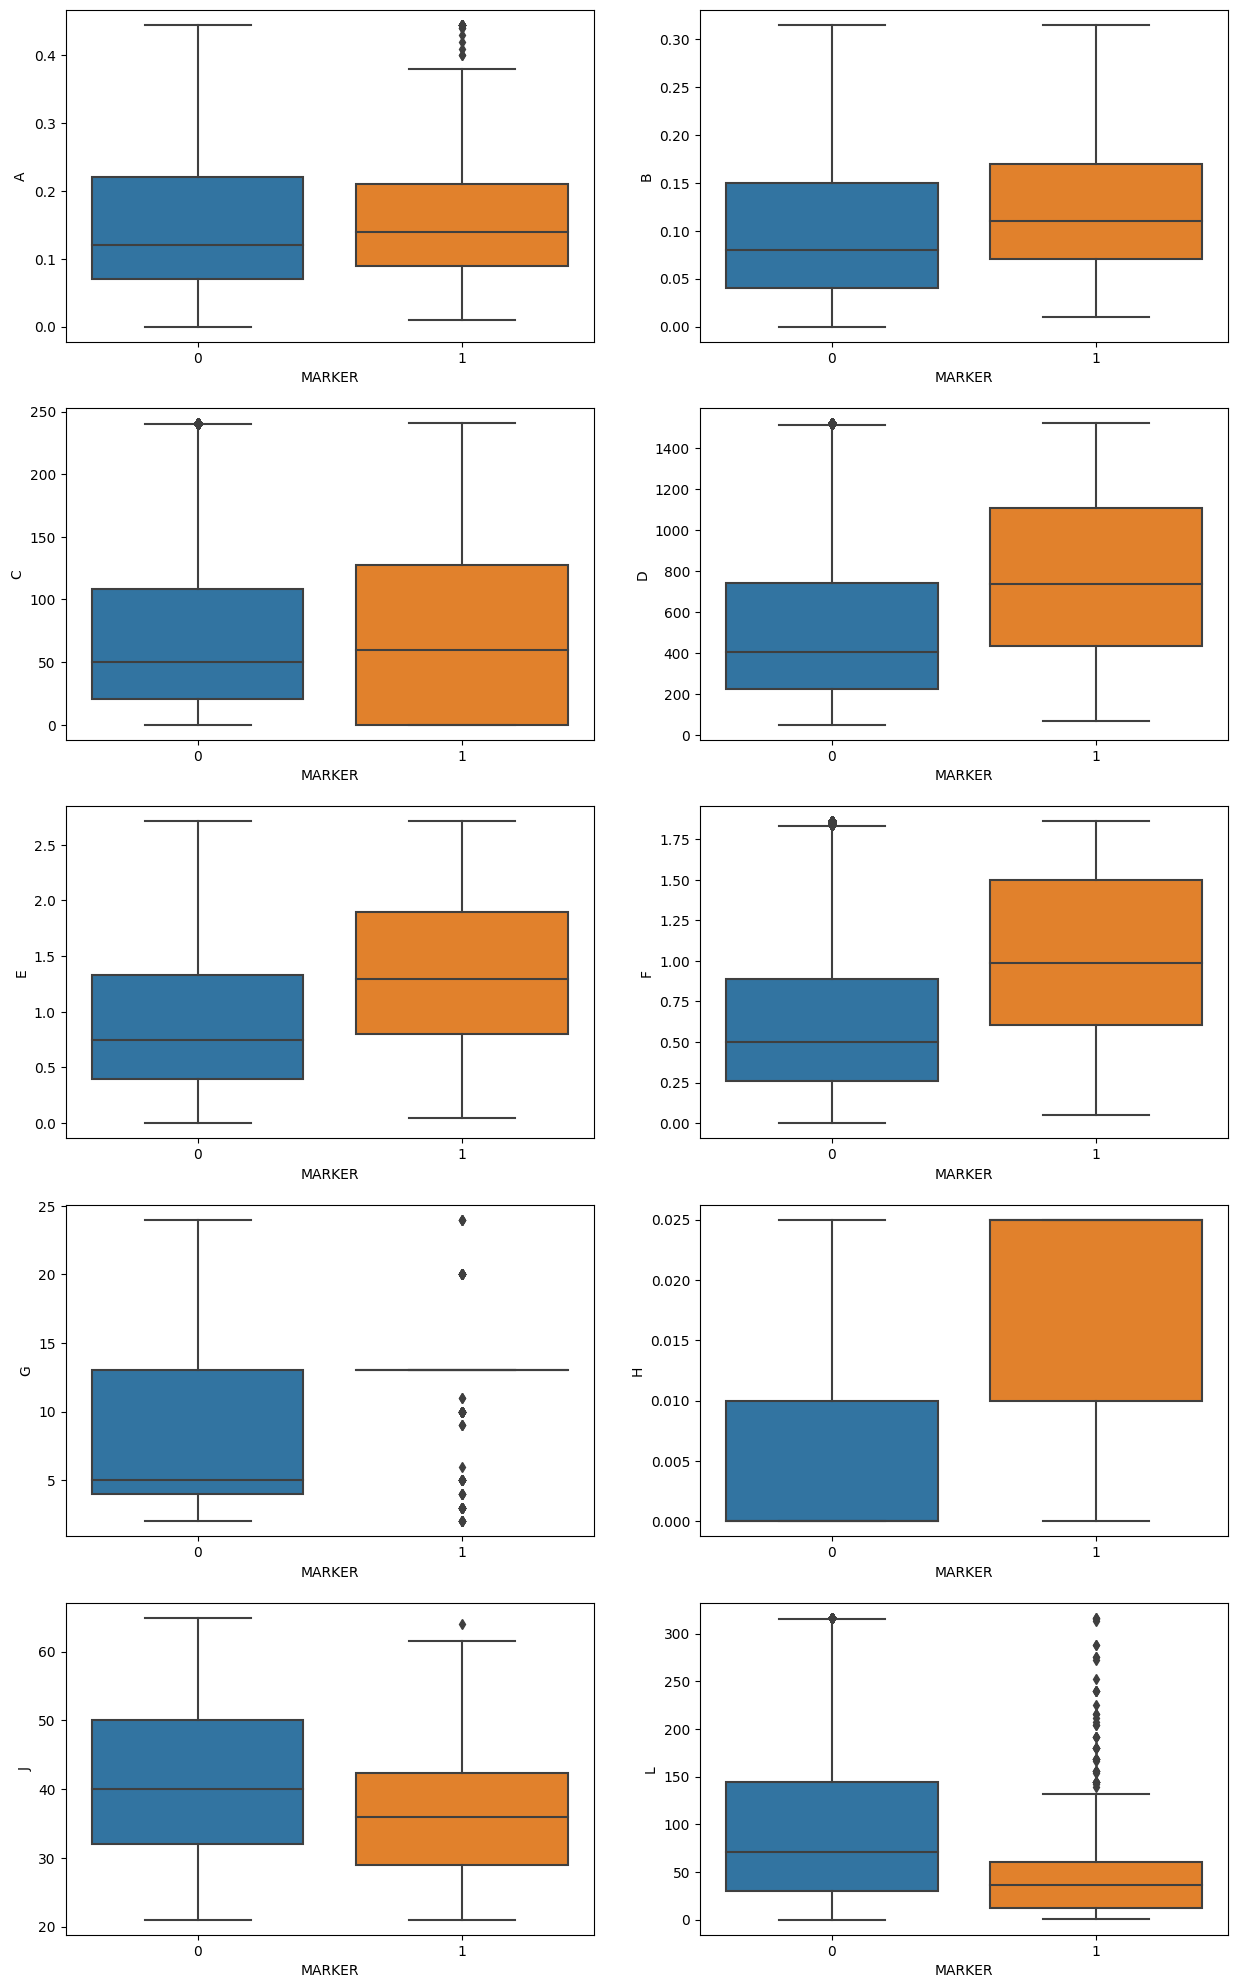

In [15]:
cols = 2
rows = len(num_features)//cols
fig, ax = plt.subplots(rows, cols, figsize=(15, 25))
for idx, feature in enumerate(num_features):
    col = idx%cols
    row = idx//cols
    sns.boxplot(data_proc_extr, x='MARKER', y=feature, ax=ax[row][col])
plt.show()

Обращаем внимание на более явное разделение классов независимой переменной H. Основная часть дефолтных клиентов находится в интервале от 1.0 до 2.5, а хороших клиентов от 0.0 до 1.0, в связи в чем уже сейчас можно сделать вывод, что данная переменная будет оказывать ключевое влияние на значение целевой переменной

Построим матрицу диаграмм рассеяния

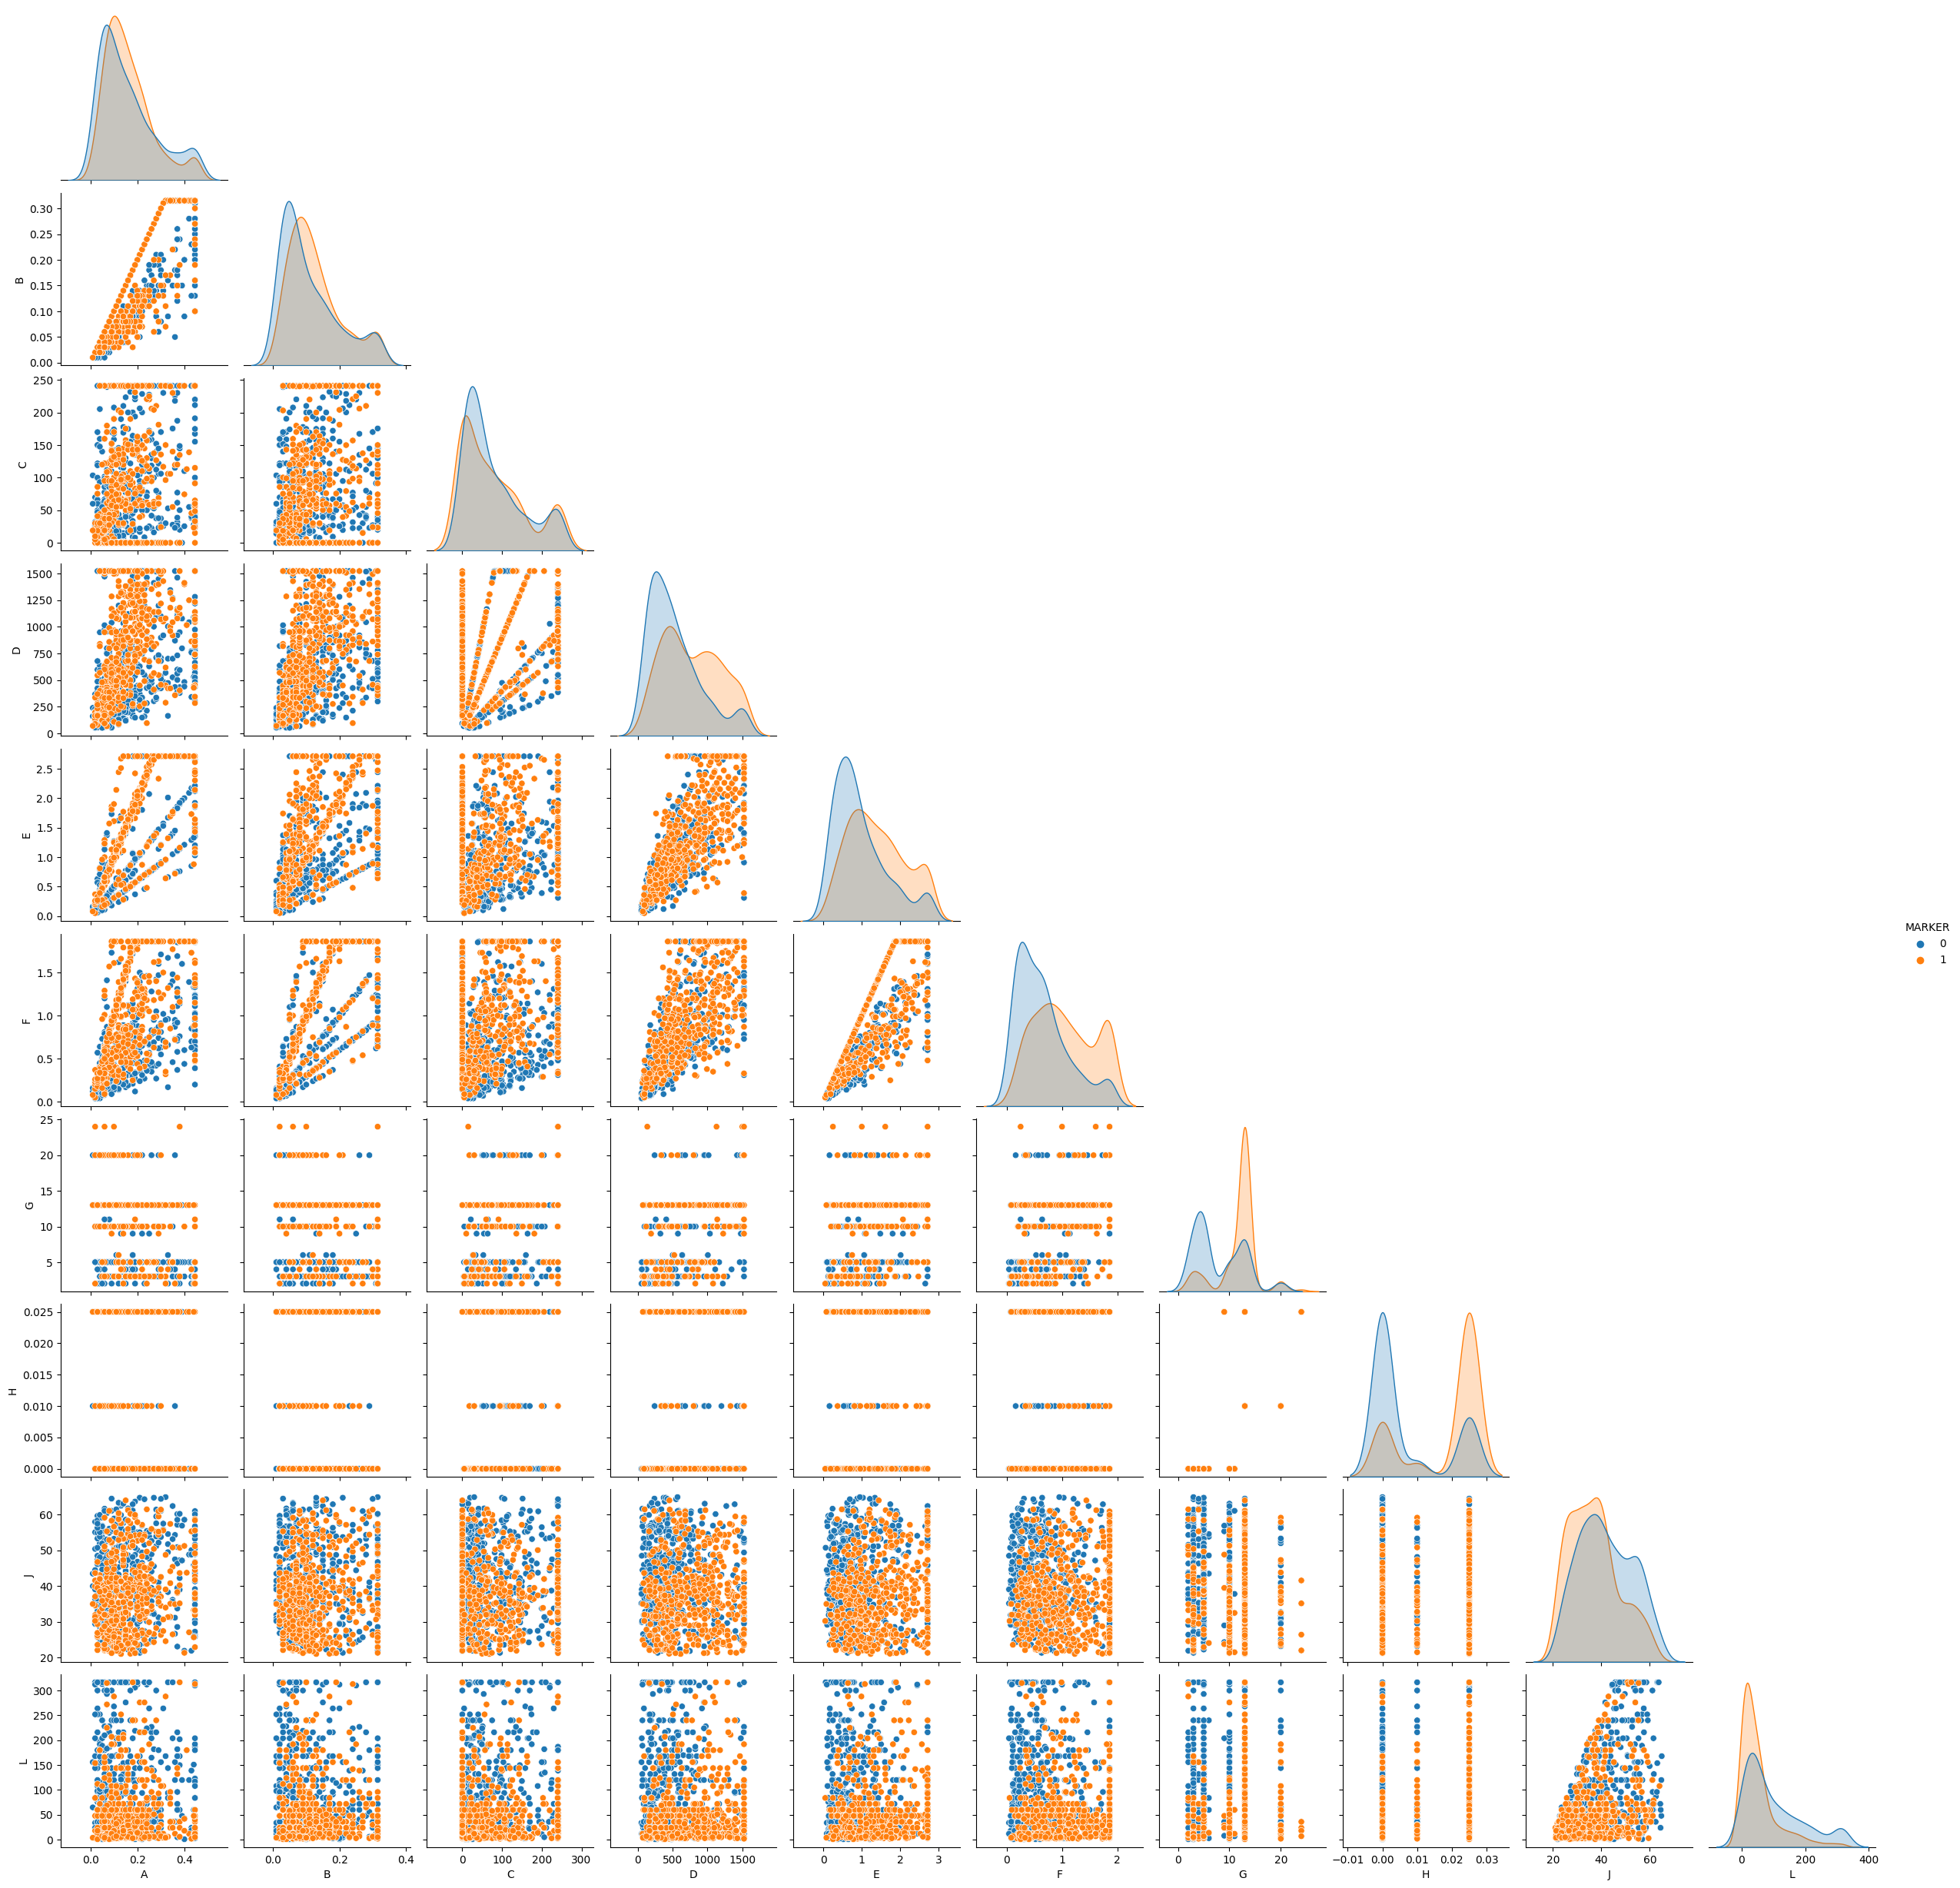

In [16]:
pair_data = pd.concat([data_proc_extr[data_proc_extr['MARKER']==0].sample(n=500), data_proc_extr[data_proc_extr['MARKER']==1]])
sns.pairplot(pair_data, hue='MARKER', corner=True)

Подтверждаем гипотезу влияния независимых переменных G и H на целевую переменную. Также замечаем, что большая часть дефолтных клиентов имеют значение перемнной L меньше 100, вероятнее всего данная переменная также будет одной из ключевых. Также визуально кажется, что переменные D и A в паре достаточно хорошо линейно разделяют классы. На данном этапе я бы выделил 5 ключевых переменных: G, H, L, D и A.
Однако на диаграммах четко прослеживается линейная зависимость между независимыми переменными

Преобразуем категориальные признаки (YES/NO) в бинарные

In [7]:
bool_features = ['R','T','U','W','X']
for i in bool_features:
    data_proc_extr[i] = data_proc_extr[i].map({'Yes': True,'No': False})

Построим матрицу корреляции Пирсона

<Axes: >

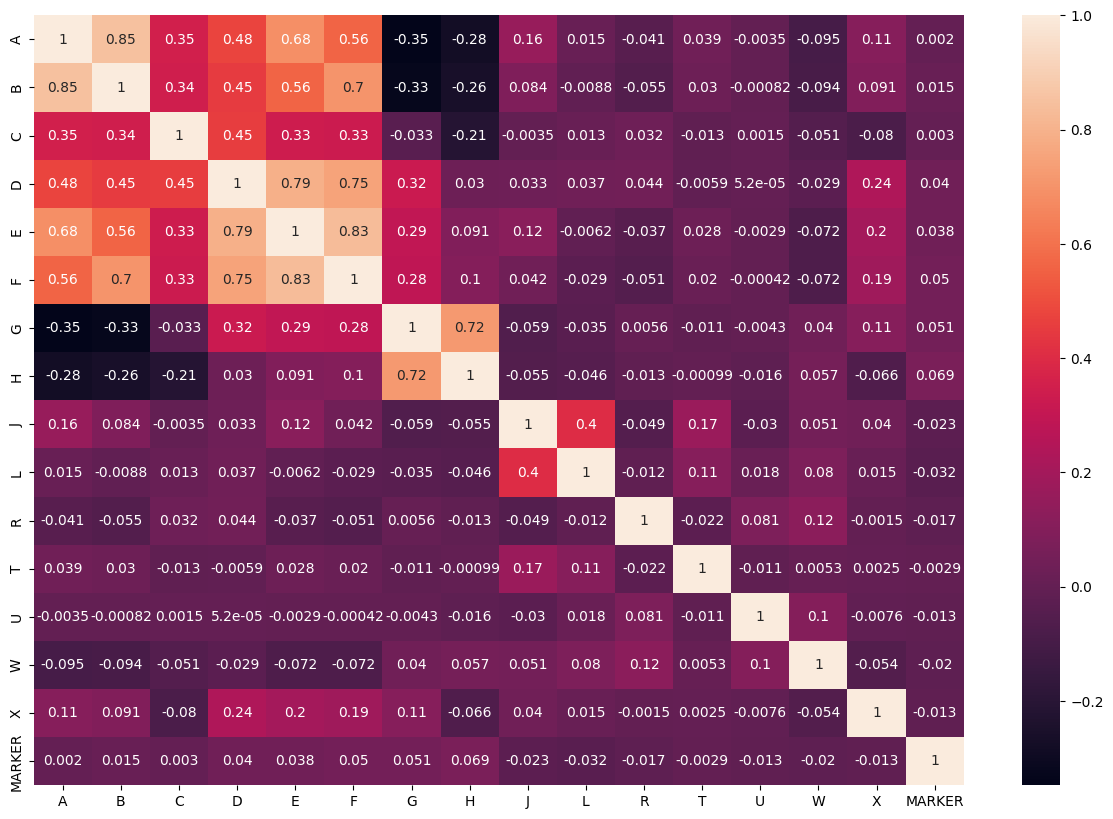

In [18]:
corr_data = data_proc_extr.select_dtypes(include=['int64','float64','bool'])
plt.subplots(figsize=(15, 10))
sns.heatmap(corr_data.corr(), annot=True)

Обращаем внимание на значение коллинеарности независимых переменных выше 0.6 у следующих пар: A и B, A и E, B и F, D и E, D и F, E и F, G и H. Так как на предыдущем этапе я выделил переменные D и A, соответственно их и сохраним, и избавимся от перемнных B, E и F. Между переменным G и H остановлюсь на переменной H, а от переменной G избавимся.

In [8]:
data_without_corr = data_proc_extr.drop(['B','E','F','G'], axis=1)

Выполним оптимальную категоризацию независимых переменных и оценим возможность перераспределения бинов в категориальных признаках 

In [20]:
from optbinning import OptimalBinning
binning_array_columns = data_without_corr.columns
category_columns = data_without_corr.select_dtypes(include='object').columns
all_binning_array = []
for i in binning_array_columns:
    x = data_without_corr[i].values
    y = data_without_corr['MARKER'].to_numpy()
    if i in category_columns:
        optb = OptimalBinning(name=i, dtype='categorical', solver='cp')
        optb.fit(x,y)
    else:
        optb = OptimalBinning(name=i, solver='cp')
        optb.fit(x,y)
    all_binning_array.append(optb)

(CVXPY) Feb 08 08:55:58 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 08 08:55:58 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [21]:
for i, g in enumerate(range(len(all_binning_array))):
    print(binning_array_columns[i], end='\n')
    print(all_binning_array[g].binning_table.build())
    print('-'*100)

A
                 Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.03)    9863   0.076971       9841     22    0.002231   
1       [0.03, 0.04)    6700   0.052287       6691      9    0.001343   
2       [0.04, 0.05)    7582   0.059170       7571     11    0.001451   
3       [0.05, 0.06)    7428   0.057968       7403     25    0.003366   
4       [0.06, 0.09)   13592   0.106072      13545     47    0.003458   
5       [0.09, 0.11)   17124   0.133636      17048     76    0.004438   
6        [0.11, inf)   65850   0.513895      65552    298    0.004525   
7            Special       0   0.000000          0      0    0.000000   
8            Missing       0   0.000000          0      0    0.000000   
Totals                128139   1.000000     127651    488    0.003808   

             WoE        IV        JS  
0        0.53653  0.017175  0.002121  
1       1.044554  0.035487  0.004245  
2       0.967445  0.035572  0.004281  
3       0.124025  0.000839  0.000105  

In [22]:
arr_iv = []
for i in range(len(all_binning_array)):
    arr_iv.append(all_binning_array[i].binning_table.build()['IV']['Totals'])
pd.Series(data=arr_iv, index=binning_array_columns)

A             0.110259
C             0.533757
D             0.532481
H             1.033902
I             0.027733
J             0.207658
K             0.038711
L             0.495577
M             0.061322
N             0.280064
O             0.221808
P             0.011289
Q             0.029307
R             0.115656
S             0.272050
T             0.002146
U             0.039864
V             0.008967
W             0.117879
X             0.047944
MARKER        0.000000
train/test    0.000000
dtype: float64

По показателю Information Value наибольшее значение у отмеченного ранее признака H, высокий показатель у признаков D и L, которые также выделялись ранее, и у признака C

In [23]:
def M_bins(x):
    if x in ['Enterpreneur', 'Head/Deputy head (organiz.)']:
        return 'Enterpreneur, Head/Deputy head (organiz.)'
    else: return x
    
data_without_corr['M'] = data_without_corr['M'].apply(lambda x: M_bins(x))


def N_bins(x):
    if x in ['Secondary education (plus special education)','Incomplete higher education','Primary or lower secondary education']:
        return 'Secondary education (plus special education),Incomplete higher education,Primary or lower secondary education'
    else: return x
    
data_without_corr['N'] = data_without_corr['N'].apply(lambda x: N_bins(x))


def O_bins(x):
    if x in ['Cohabitation','Divorced/widow']:
        return 'Cohabitation, Divorced/widow'
    else: return x
    
data_without_corr['O'] = data_without_corr['O'].apply(lambda x: O_bins(x))


def P_bins(x):
    if x in ['3 Three', '0 Zero']:
        return '3 Three, 0 Zero'
    elif x in ['1 One', 'More than 3']:
        return '1 One, More than 3'
    else: return x
    
data_without_corr['P'] = data_without_corr['P'].apply(lambda x: P_bins(x))


def Q_bins(x):
    if x in ['otherwise', 'rent/hire']:
        return 'otherwise, rent/hire'
    else: return x
    
data_without_corr['Q'] = data_without_corr['Q'].apply(lambda x: Q_bins(x))


def S_bins(x):
    if x in ['Student', 'Pensioner']:
        return 'Student, Pensioner'
    else: return x
    
data_without_corr['S'] = data_without_corr['S'].apply(lambda x: S_bins(x))


def V_bins(x):
    if x in ['Yes', 'Few']:
        return 'Yes, Few'
    else: return x
    
data_without_corr['V'] = data_without_corr['V'].apply(lambda x: V_bins(x))

In [24]:
data_without_corr['P'].value_counts()

P
3 Three, 0 Zero       67250
1 One, More than 3    37681
2 Two                 23208
Name: count, dtype: int64

Забегая вперед отмечу, что преобразование категориальных признаков, описанное выше не привело к улучшению качества модели, поэтому данная обработка не осуществлялась при построении окончательной модели

Преобразуем все категориальные признаки в бинарные методом One-hot encoding и разделим выборку на обучающую и тестовую

In [9]:
data_one_hot = pd.get_dummies(data_without_corr, columns=data_without_corr.select_dtypes(include='object').columns)
train_data = data_one_hot[data_one_hot['train/test_train']==True].drop(['train/test_test','train/test_train'], axis=1)
test_data = data_one_hot[data_one_hot['train/test_train']==False].drop(['train/test_test','train/test_train'], axis=1)

In [14]:
train_data.columns

Index(['A', 'C', 'D', 'H', 'J', 'L', 'R', 'T', 'U', 'W', 'X', 'MARKER',
       'I_Man', 'I_Woman', 'K_Brest region', 'K_Gomel region',
       'K_Grodno region', 'K_Minsk', 'K_Minsk region', 'K_Mogilev region',
       'K_Vitebsk region', 'M_Enterpreneur', 'M_Head/Deputy head (division)',
       'M_Head/Deputy head (organiz.)', 'M_NE employee', 'M_Pensioner',
       'N_Higher education (one or more)', 'N_Incomplete higher education',
       'N_Primary or lower secondary education',
       'N_Secondary education (plus special education)', 'O_Cohabitation',
       'O_Divorced/widow', 'O_Married', 'O_Single/unmarried', 'P_0 Zero',
       'P_1 One', 'P_2 Two', 'P_3 Three', 'P_More than 3', 'Q_otherwise',
       'Q_property', 'Q_rent/hire', 'S_No couple', 'S_Pensioner', 'S_Student',
       'S_Unemployed', 'S_Works', 'V_Few', 'V_No', 'V_Yes'],
      dtype='object')

In [10]:
X_train = train_data.drop(['MARKER'], axis=1)
y_train = train_data['MARKER']
X_test = test_data.drop(['MARKER'], axis=1)
y_test = test_data['MARKER']

In [11]:
y_train.value_counts()

MARKER
0    89392
1      342
Name: count, dtype: int64

Обращаем внимание на сильный дисбаланс классов, и в связи с тем, что количество наблюдений в минорном классе в обучающей выборке составляет всего 342, в качестве метода балансировки классов будем использовать метод Class Weighting, установив для каждой модели параметр class_weight = balanced

In [12]:
y_test.value_counts()

MARKER
0    38259
1      146
Name: count, dtype: int64

Производим нормализацию данных методом MinMaxScaler, это необходимо для обеспечения корректности работы алгоритма логистической регресии. Что касается алгоритмов случайного леса и градиентного бустинга, то данные алгоритмы не чувствительны к ненормализованным данным, впрочем как и к выбросам в данных, поэтому для наглядности данные алгоритмы будем обучать без нормализации, но с обработкой выбросов

In [13]:
from sklearn.preprocessing import MinMaxScaler
scal = MinMaxScaler()
X_train_scal = scal.fit_transform(X_train)
X_test_scal = scal.transform(X_test)

# Hyperparameters optimization

Осуществляем подбор гипертараметров моделей LogisticRegression, RandomForestClassifier и LGBMClassifier при помощи фреймворка Optuna

In [15]:
import optuna
from sklearn.model_selection import train_test_split

В качестве стратегии подбора параметров мною применялся метод многоцелевой оптимизации путем максимизации метрик ROC AUC и balanced accuracy. К основной метрике ROC AUC я добавил balanced accuracy, чтобы нивелировать дисбаланс классов и стремление модели максимизировать ROC AUC за счет более точных предсказаний мажорного класса, что оказало бы негативное влияние на предсказание минорного класса (дефолтов), что является наиболее приоритетным в рамках конкретной задачи

In [36]:
def objective_lr(trial, X=X_train_scal, y=y_train):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    param = {
        'C': trial.suggest_float('C', 1e-2, 30, log=True),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'newton-cg', 'newton-cholesky', 'lbfgs', 'sag', 'saga']),
        'max_iter': trial.suggest_categorical('max_iter', [1000]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
        'tol': trial.suggest_float('tol', 1e-6, 1e-3),
    }
    
    if param['solver'] in ['liblinear', 'saga']:
        param['penalty'] = trial.suggest_categorical('penalty', ['l1', 'l2'])
    if param['solver'] in ['liblinear', 'saga', 'sag']:
        param['random_state'] = trial.suggest_categorical('random_state', [42])

    model_val = LogisticRegression(**param)
    model_val.fit(X_tr, y_tr)
    bal_acc = balanced_accuracy_score(y_val, model_val.predict(X_val))
    roc_auc = roc_auc_score(y_val, model_val.predict_proba(X_val)[:,1])
    return bal_acc, roc_auc

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lr = optuna.create_study(directions=['maximize','maximize'])
study_lr.optimize(objective_lr, n_trials=100)

optuna.visualization.plot_pareto_front(study_lr, target_names=['balanced_accuracy','roc_auc'])

D:\py projects\pythonProject\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

D:\py projects\pythonProject\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

D:\py projects\pythonProject\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

D:\py projects\pythonProject\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

D:\py projects\pythonProject\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

D:\py projects\pythonProject\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which me

Выводим best_trials и затем проверяем на тестовых данных результаты каждого набора параметров

In [37]:
for i in range(len(study_lr.best_trials)):
    print(f'Номер итерации: {study_lr.best_trials[i].number}')
    print(f'Параметры модели: {study_lr.best_trials[i].params}')
    model_lr = LogisticRegression(**study_lr.best_trials[i].params).fit(X_train_scal, y_train)
    print(f'Матрица ошибок:\n {confusion_matrix(y_test, model_lr.predict(X_test_scal))}')
    print(f'ROC_AUC: {roc_auc_score(y_test, model_lr.predict_proba(X_test_scal)[:,1])}')
    print('-'*100)

Номер итерации: 12
Параметры модели: {'C': 0.05088862975195974, 'solver': 'lbfgs', 'max_iter': 1000, 'class_weight': 'balanced', 'tol': 0.0008825155528730314}
Матрица ошибок:
 [[30419  7840]
 [   24   122]]
ROC_AUC: 0.8824794380908494
----------------------------------------------------------------------------------------------------
Номер итерации: 21
Параметры модели: {'C': 0.011533710551722077, 'solver': 'newton-cg', 'max_iter': 1000, 'class_weight': 'balanced', 'tol': 0.0005197549491532817}
Матрица ошибок:
 [[30374  7885]
 [   24   122]]
ROC_AUC: 0.8834130531378237
----------------------------------------------------------------------------------------------------
Номер итерации: 23
Параметры модели: {'C': 0.029566818075301662, 'solver': 'lbfgs', 'max_iter': 1000, 'class_weight': 'balanced', 'tol': 0.0006533535446586238}
Матрица ошибок:
 [[30420  7839]
 [   24   122]]
ROC_AUC: 0.8827440369478826
---------------------------------------------------------------------------------------

In [38]:
def objective_forest(trial, X=X_train, y=y_train):
    
    param = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
    'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt']),
    'max_depth': trial.suggest_int('max_depth', 3, 50),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
    }

    model_val = RandomForestClassifier(**param)
    stf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    bal_acc = cross_val_score(model_val, X, y, scoring='balanced_accuracy', cv=stf, n_jobs=-1).mean()
    roc_auc = cross_val_score(model_val, X, y, scoring='roc_auc', cv=stf, n_jobs=-1).mean()
    return bal_acc, roc_auc

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_forest = optuna.create_study(directions=['maximize','maximize'])
study_forest.optimize(objective_forest, n_trials=300)

optuna.visualization.plot_pareto_front(study_forest, target_names=['balanced_accuracy','roc_auc'])

In [39]:
for i in range(len(study_forest.best_trials)):
    print(f'Номер итерации: {study_forest.best_trials[i].number}')
    print(f'Параметры модели: {study_forest.best_trials[i].params}')
    model_forest = RandomForestClassifier(**study_forest.best_trials[i].params).fit(X_train, y_train)
    print(f'Матрица ошибок:\n {confusion_matrix(y_test, model_forest.predict(X_test))}')
    print(f'ROC_AUC: {roc_auc_score(y_test, model_forest.predict_proba(X_test)[:,1])}')
    print('-'*100)

Номер итерации: 171
Параметры модели: {'n_estimators': 133, 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': 'balanced'}
Матрица ошибок:
 [[30698  7561]
 [   31   115]]
ROC_AUC: 0.871892082335717
----------------------------------------------------------------------------------------------------
Номер итерации: 194
Параметры модели: {'n_estimators': 133, 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'class_weight': 'balanced'}
Матрица ошибок:
 [[31292  6967]
 [   31   115]]
ROC_AUC: 0.8760159217618059
----------------------------------------------------------------------------------------------------
Номер итерации: 251
Параметры модели: {'n_estimators': 82, 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2, 'class_weight': 'balanced'}
Матрица ошибок:
 [[31089  7170]
 [   31   115]]
ROC_AUC: 0.8733626826815214
-----------------------------------------------

In [33]:
def objective_lgbm(trial, X=X_train, y=y_train):
    
    param = {
    'device_type': trial.suggest_categorical('device_type', ['gpu']),
    'max_depth': trial.suggest_int('max_depth', 3, 6),
    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
    'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
    'learning_rate': trial.suggest_float('learning_rate', 1e-01, 0.3),
    'reg_alpha': trial.suggest_float("lambda_l1", 0.0, 100.0),
    'reg_lambda': trial.suggest_float("lambda_l2", 0.0, 100.0),
    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1),
    'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
    'verbose': trial.suggest_categorical('verbose', [-1]),
    }

    model_val = LGBMClassifier(**param)
    stf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    bal_acc = cross_val_score(model_val, X, y, scoring='balanced_accuracy', cv=stf, n_jobs=-1).mean()
    roc_auc = cross_val_score(model_val, X, y, scoring='roc_auc', cv=stf, n_jobs=-1).mean()
    return bal_acc, roc_auc

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm = optuna.create_study(directions=['maximize','maximize'])
study_lgbm.optimize(objective_lgbm, n_trials=300)

optuna.visualization.plot_pareto_front(study_lgbm, target_names=['balanced_accuracy','roc_auc'])

D:\py projects\pythonProject\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "D:\py projects\pythonProject\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\py projects\pythonProject\venv\lib\site-packages\lightgbm\sklearn.py", line 1187, in fit
    super().fit(
  File "D:\py projects\pythonProject\venv\lib\site-packages\lightgbm\sklearn.py", line 885, in fit
    self._Booster = train(
  File "D:\py projects\pythonProject\venv\lib\site-

In [34]:
for i in range(len(study_lgbm.best_trials)):
    print(f'Номер итерации: {study_lgbm.best_trials[i].number}')
    print(f'Параметры модели: {study_lgbm.best_trials[i].params}')
    model_lgbm = LGBMClassifier(**study_lgbm.best_trials[i].params).fit(X_train, y_train)
    print(f'Матрица ошибок:\n {confusion_matrix(y_test, model_lgbm.predict(X_test))}')
    print(f'ROC_AUC: {roc_auc_score(y_test, model_lgbm.predict_proba(X_test)[:,1])}')
    print('-'*100)

Номер итерации: 155
Параметры модели: {'device_type': 'gpu', 'max_depth': 3, 'n_estimators': 84, 'min_child_weight': 2, 'learning_rate': 0.10971295113748508, 'lambda_l1': 55.95133560163763, 'lambda_l2': 75.20379572526575, 'subsample': 0.9444839833034385, 'colsample_bytree': 0.6469655193899989, 'class_weight': 'balanced', 'verbose': -1}
Матрица ошибок:
 [[31965  6294]
 [   31   115]]
ROC_AUC: 0.892885262559763
----------------------------------------------------------------------------------------------------
Номер итерации: 189
Параметры модели: {'device_type': 'gpu', 'max_depth': 3, 'n_estimators': 91, 'min_child_weight': 10, 'learning_rate': 0.14040291591888635, 'lambda_l1': 93.23005784726617, 'lambda_l2': 64.75143933403541, 'subsample': 0.7444870604866419, 'colsample_bytree': 0.794266169066471, 'class_weight': 'balanced', 'verbose': -1}
Матрица ошибок:
 [[32369  5890]
 [   28   118]]
ROC_AUC: 0.8952740818079514
------------------------------------------------------------------------

Применив стратегию подбора гиперпараметров, описанную выше, были отобраны параметры моделей, которые показывали более высокую точность с учетом незначительного уменьшения метрики ROC AUC

In [40]:
# модель LogisticRegression
log_reg = LogisticRegression(C=0.029566818075301662,
                           solver='lbfgs',
                           tol=0.0008825155528730314,
                           class_weight='balanced',
                           max_iter=200)

In [41]:
# модель RandomForest
rand_for = RandomForestClassifier(n_estimators=257,
                                  max_depth=5, 
                                  min_samples_split=8, 
                                  min_samples_leaf=1, 
                                  class_weight='balanced')

In [42]:
# модель LGBM
lgbm = LGBMClassifier(max_depth=3,
                      n_estimators=91,
                      min_child_weight=10,
                      learning_rate=0.14040291591888635,
                      lambda_l1=93.23005784726617,
                      lambda_l2=64.75143933403541,
                      subsample=0.7444870604866419,
                      colsample_bytree=0.794266169066471,
                      verbose=-1,
                      class_weight='balanced')

# Training models and calculate metrics

Записываем функцию обучения моделей и расчета метрик: Accuracy, Recall, ROC_AUC

In [43]:
def train_pred():
    for model in [log_reg, rand_for, lgbm]:
        if model==log_reg:
            model.fit(X_train_scal, y_train)
            pred = model.predict(X_test_scal)
            pred_prob = model.predict_proba(X_test_scal)[:,1]
        else:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            pred_prob = model.predict_proba(X_test)[:,1]
        matrix = confusion_matrix(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        recall = recall_score(y_test, pred)
        roc_auc = roc_auc_score(y_test,pred_prob)
        print(f'Модель: {model}')
        print(f'Матрица ошибок:\n {matrix}')
        print(f'Accuracy: {accuracy}')
        print(f'Recall: {recall}')
        print(f'ROC_AUC: {roc_auc}')
        print('-'*100)

In [45]:
train_pred()

Модель: LogisticRegression(C=0.029566818075301662, class_weight='balanced',
                   max_iter=200, tol=0.0008825155528730314)
Матрица ошибок:
 [[30420  7839]
 [   24   122]]
Accuracy: 0.7952610337195678
Recall: 0.8356164383561644
ROC_AUC: 0.8827440369478826
----------------------------------------------------------------------------------------------------
Модель: RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=8, n_estimators=257)
Матрица ошибок:
 [[32170  6089]
 [   32   114]]
Accuracy: 0.8406197109751334
Recall: 0.7808219178082192
ROC_AUC: 0.8798377461190079
----------------------------------------------------------------------------------------------------
Модель: LGBMClassifier(class_weight='balanced', colsample_bytree=0.794266169066471,
               lambda_l1=93.23005784726617, lambda_l2=64.75143933403541,
               learning_rate=0.14040291591888635, max_depth=3,
               min_child_weight=10, n_estimator

Ожидаемо наилучший результат показала модель градиентного бустинга (LGBMClassifier), показатель ROC AUC = 0.8953, что более чем на 1% процент выше, чем у LogisticRegression и RandomForestClassifier, и общей точностью (Accuracy) 84.6%, что на 5% выше, чем у модели LogisticRegression - 79.5%, и сопоставимо с показателем точности модели RandomForestClassifier - 84.1%
Однако в свою очередь модель LogisticRegression показала наилучшую способность предсказывать дефолты, показатель recall по минорному классу составил 0.84, LGBMClassifier - 0.81, RandomForestClassifier - 0.78

Строим ROC-кривые каждой модели на одном графике

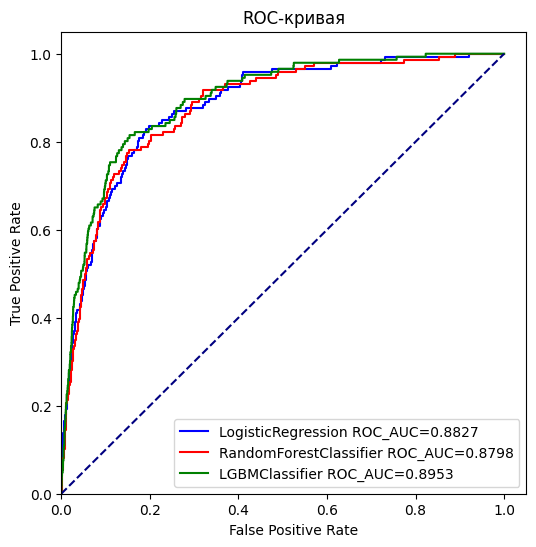

In [46]:
prob_lr = log_reg.predict_proba(X_test_scal)[:,1]
prob_for = rand_for.predict_proba(X_test)[:,1]
prob_lgbm = lgbm.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, treshold_lr = roc_curve(y_test, prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)
fpr_for, tpr_for, treshold_for = roc_curve(y_test, prob_for)
auc_for = auc(fpr_for, tpr_for)
fpr_lgbm, tpr_lgbm, treshold_lgbm = roc_curve(y_test, prob_lgbm)
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
plt.subplots(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', label='LogisticRegression ROC_AUC=%0.4f' % auc_lr)
plt.plot(fpr_for, tpr_for, color='red', label='RandomForestClassifier ROC_AUC=%0.4f' % auc_for)
plt.plot(fpr_lgbm, tpr_lgbm, color='green', label='LGBMClassifier ROC_AUC=%0.4f' % auc_lgbm)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

# Feature importances

Оценим какие признаки оказывали наибольшее влияние на предсказания каждой модели

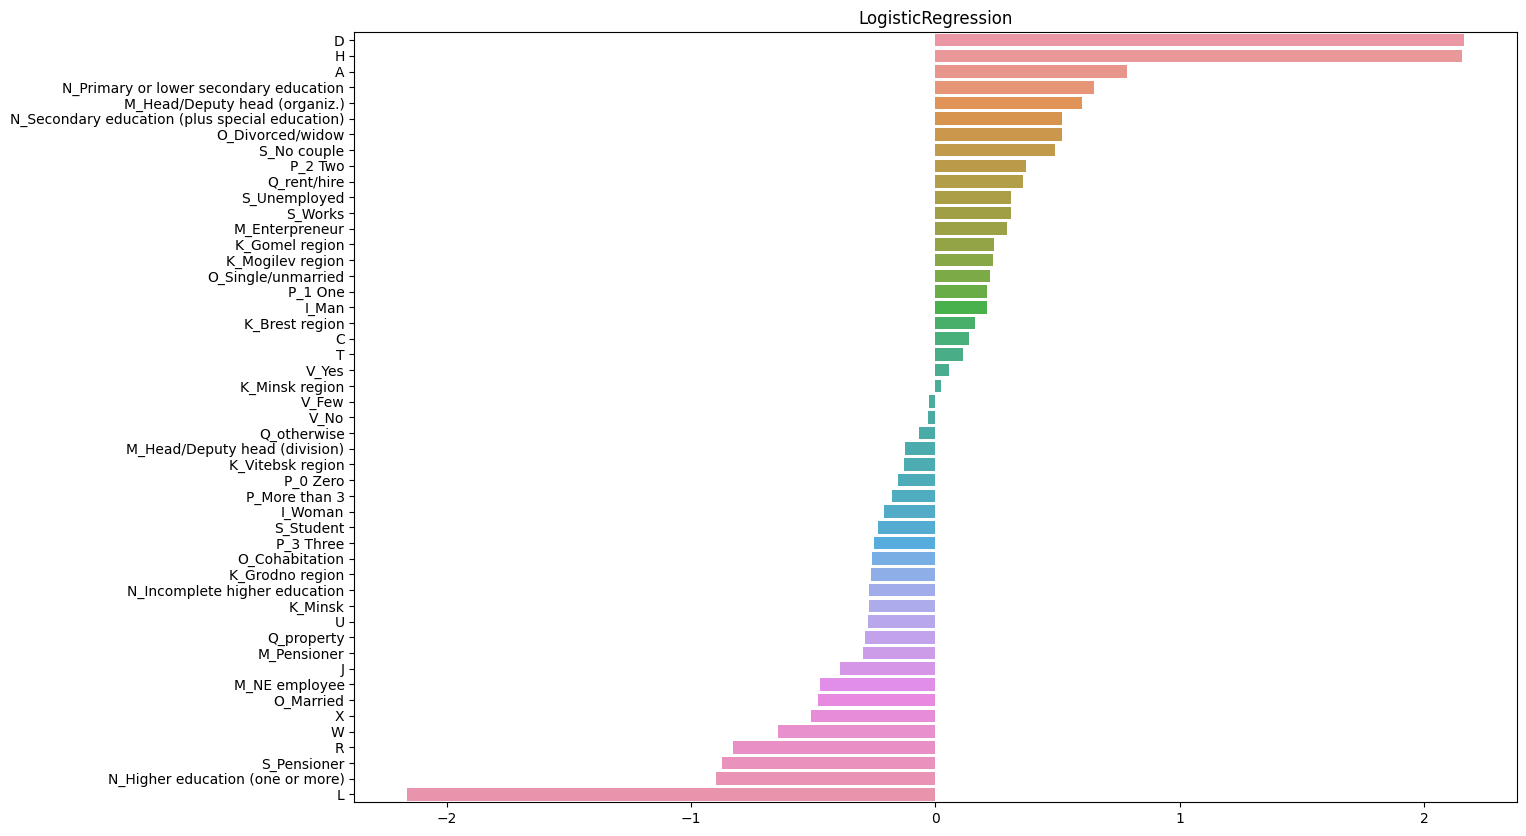

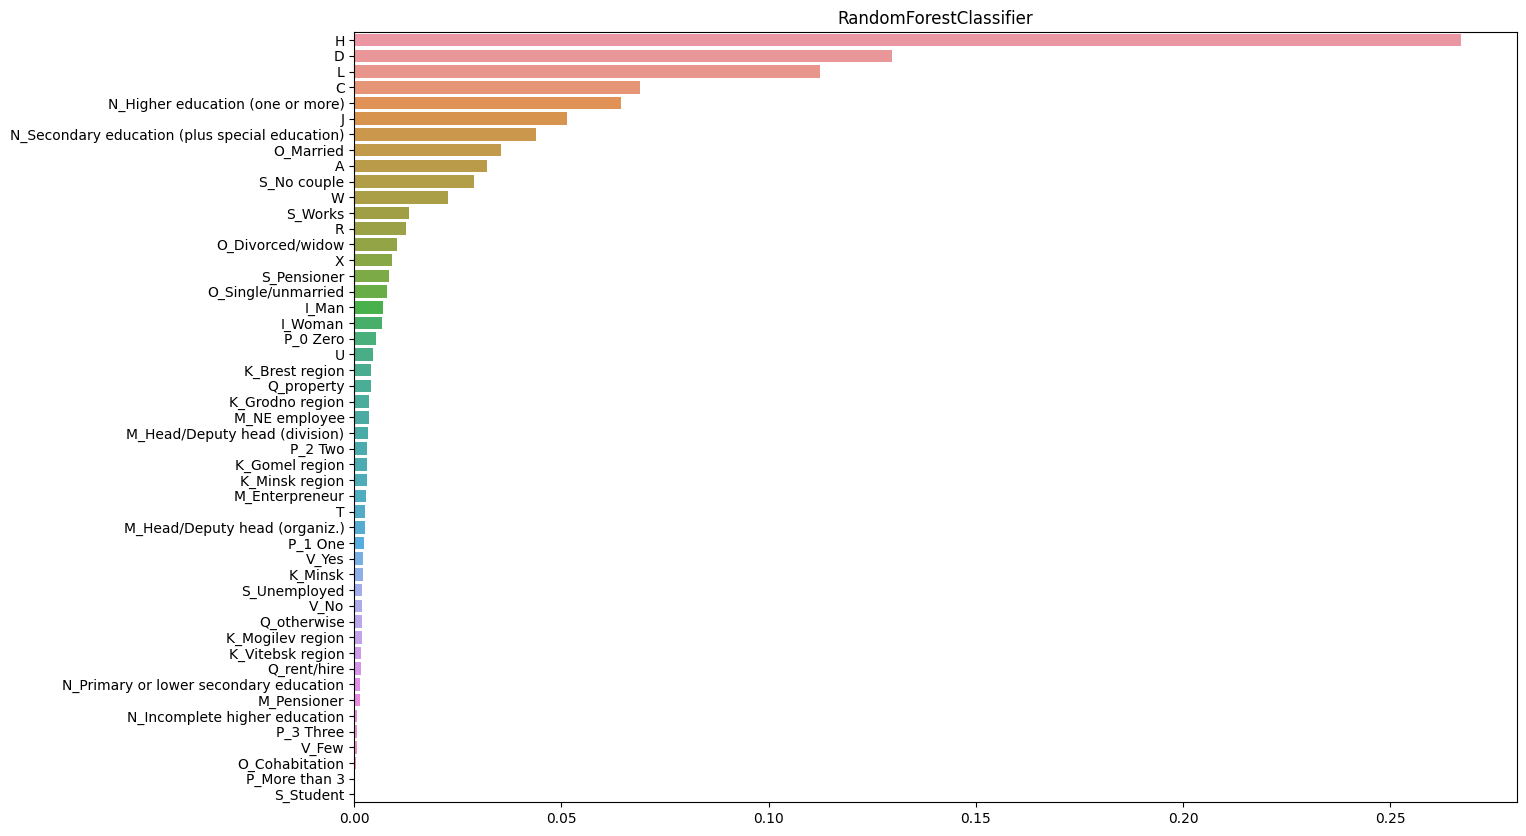

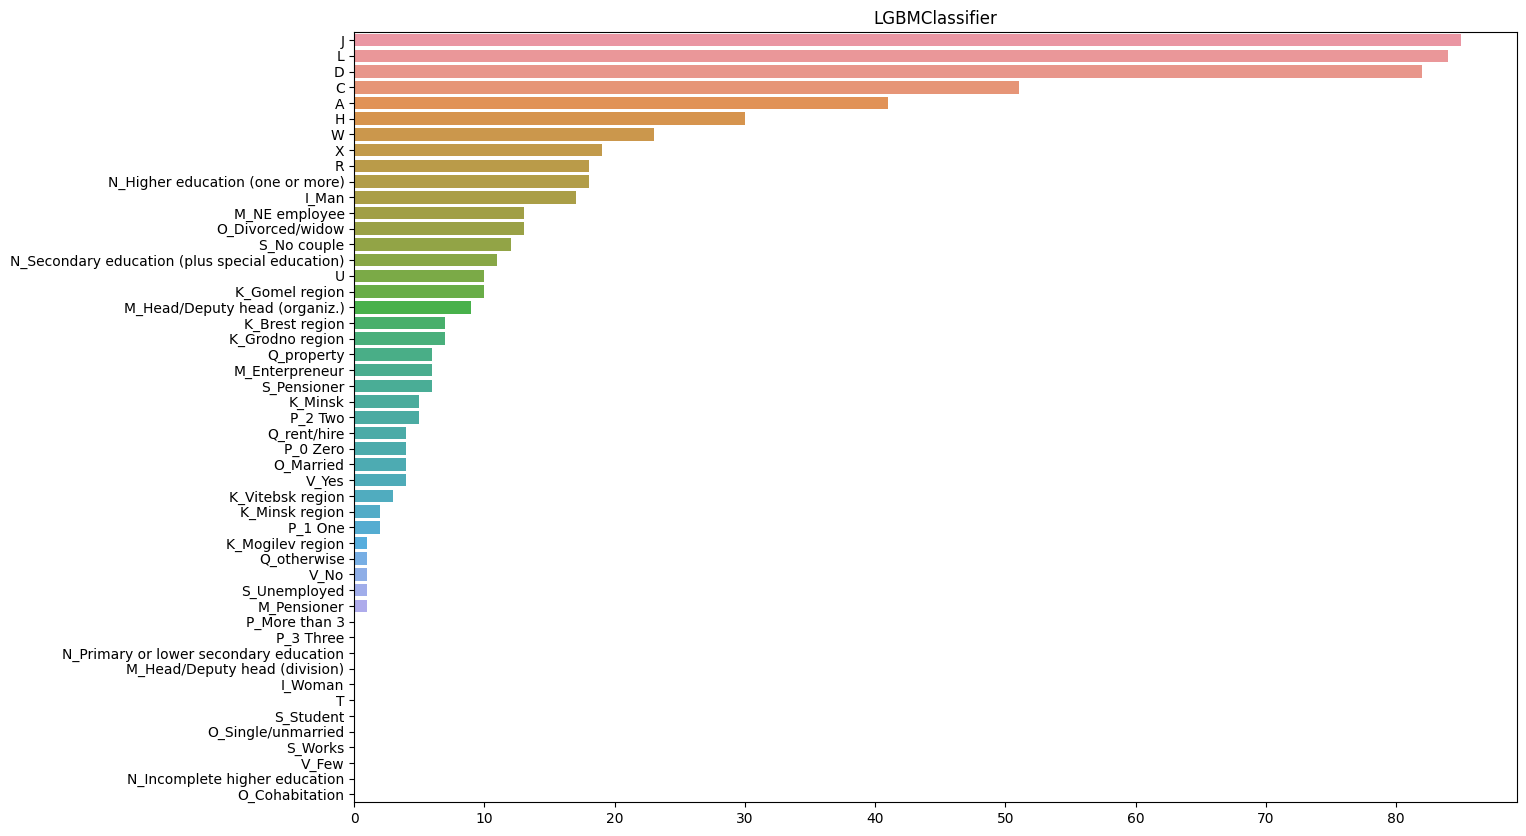

In [47]:
model_names = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier']
for i, model in enumerate([log_reg, rand_for, lgbm]):
    if model==log_reg:
        feat_imp = pd.Series(model.coef_.reshape(-1), index=train_data.drop('MARKER', axis=1).columns).sort_values(ascending=False)
    else:
        feat_imp = pd.Series(model.feature_importances_.reshape(-1), index=train_data.drop('MARKER', axis=1).columns).sort_values(ascending=False)
    plt.subplots(figsize=(15, 10))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(model_names[i])
    plt.show()

Наиболее важными признаками в моделях логистической регресии и случайного леса оказались отмеченные мною ранее H, D и L. Однако в модели градиентного бустинга неожиданно признак H не попадает даже в топ-5, а выделяется помимо D и L, еще признак J, что обусловлено способностью алгоритма градиентного бустинга находить более сложные закономерности, в связи с чем интерпретировать его результаты очень сложно, в отличии от той же модели логистической регресии.